In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nb_mesh = 5
nb_line = 3

In [3]:
def show_state(state):
    plt.subplot(1,3,1)
    plt.imshow(state[:,:,0], 'Reds')
    plt.title('o')
    plt.clim(0,1)

    ax = plt.gca()
    ax.set_xticks(np.arange(0, nb_mesh, 1))
    ax.set_yticks(np.arange(0, nb_mesh, 1))
    ax.set_xticks(np.arange(-.5, nb_mesh+0.5, 1), minor=True)
    ax.set_yticks(np.arange(-.5, nb_mesh+0.5, 1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    plt.subplot(1,3,2)
    plt.imshow(state[:,:,1], 'Blues')
    plt.title('x')
    plt.clim(0,1)

    ax = plt.gca()
    ax.set_xticks(np.arange(0, nb_mesh, 1))
    ax.set_yticks(np.arange(0, nb_mesh, 1))
    ax.set_xticks(np.arange(-.5, nb_mesh+0.5, 1), minor=True)
    ax.set_yticks(np.arange(-.5, nb_mesh+0.5, 1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    
    plt.subplot(1,3,3)
    plt.imshow(state[:,:,2], 'RdBu')
    plt.title('move')
    plt.clim(0,1)

    ax = plt.gca()
    ax.set_xticks(np.arange(0, nb_mesh, 1))
    ax.set_yticks(np.arange(0, nb_mesh, 1))
    ax.set_xticks(np.arange(-.5, nb_mesh+0.5, 1), minor=True)
    ax.set_yticks(np.arange(-.5, nb_mesh+0.5, 1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

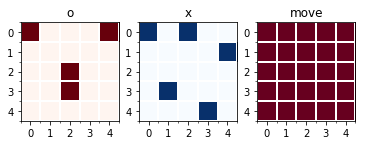

In [4]:
import numpy as np

# 1チャンネル目が○、2チャンネル目が×, 3チャンネル目が手番

board = np.zeros((nb_mesh,nb_mesh,3))
board[:,:,0] = 1

board = np.random.random((nb_mesh,nb_mesh,3))
board = board>0.8
#board[:,:,1] = board[:,:,0]-1
board[:,:,-1] = 0

show_state(board)

In [5]:
from keras.layers import Input, Conv2D, Activation, BatchNormalization, Flatten, Dense
from keras.models import Model
from keras.optimizers import Adam

state = h = Input((nb_mesh,nb_mesh,3))

h = Dense(10, activation='relu')(h)
h = Dense(10, activation='relu')(h)

#h = Conv2D(4, (3,3), padding='same')(h)
#h = BatchNormalization()(h)
#h = Activation('relu')(h)

#h = Conv2D(4, (3,3), padding='same')(h)
#h = BatchNormalization()(h)
#h = Activation('relu')(h)

h = Flatten()(h)
value = Dense(1)(h)

value_function = Model(state, value)
optimizer = Adam(lr=1e-4)
value_function.compile(loss='mse', optimizer=optimizer)
value_function.summary()

/Users/ruhokondo/Programming/anaconda3/envs/dl35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/ruhokondo/Programming/anaconda3/envs/dl35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5, 5, 3)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 5, 5, 10)          40        
_________________________________________________________________
dense_2 (Dense)              (None, 5, 5, 10)          110       
_________________________________________________________________
flatten_1 (Flatten)          (None, 250)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 251       
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


In [6]:
def get_permitted_actions(state):
    '''
    ○および×が置かれていない座標インデックスを返す。
    '''
    return np.where(state[:,:,0]+state[:,:,1]==0)

In [7]:
import copy

def transition(current_state, action):
    '''
    action は ○ もしくは × を置く state のインデックス。
    2チャンネル目が手番を表しているので、遷移後は手番を入れ替える。
    '''
    next_state = copy.deepcopy(current_state)
    if current_state[:,:,-1][0,0]==0: # ○の手番の場合
        next_state[action+(0,)] = 1
        next_state[:,:,-1] = np.ones((nb_mesh,nb_mesh))
    else: # ×の手番の場合
        next_state[action+(1,)] = 1
        next_state[:,:,-1] = np.zeros((nb_mesh,nb_mesh))
    return next_state

In [8]:
def get_best_action(current_state, value_function):
    '''
    行動空間が狭いので全探索する。
    '''
    a0,a1 = get_permitted_actions(current_state)
    max_value = -1e100
    for action in zip(a0,a1):
        next_state = transition(current_state, action)
        next_value = value_function.predict(np.expand_dims(next_state,0)).squeeze() # バッチの次元を拡張して入力する。
        if next_value>max_value:
            max_value = next_value
            best_action = action
    return max_value, best_action

In [9]:
def judge_game(state):
    winner = None
    checked = np.zeros(state.shape[:2])
    
    try:
        for i in range(state.shape[0]):
            for j in range(state.shape[1]):
                s = state[i,j,:2].argmax(-1)

                # 右側をチェック
                count = 0
                for jj in range(j,min(j+nb_line,state.shape[1])):
                    if state[i,jj,s]==1:
                        count += 1
                    if count==nb_line:
                        winner = s
                        raise Exception
                    
                # 下側をチェック
                count = 0
                for ii in range(i,min(i+nb_line,state.shape[0])):
                    if state[ii,j,s]==1:
                        count += 1
                    if count==nb_line:
                        winner = s
                        raise Exception
                        
                # 右下をチェック
                count = 0
                for ii,jj in zip(range(i,min(i+nb_line,state.shape[0])),range(j,min(j+nb_line,state.shape[1]))):
                    if state[ii,jj,s]==1:
                        count += 1
                    if count==nb_line:
                        winner = s
                        raise Exception
                        
                # 左下をチェック
                count = 0
                for ii,jj in zip(range(i,max(i-nb_line,0)-1,-1),range(j,min(j+nb_line,state.shape[1]))):
                    if state[ii,jj,s]==1:
                        count += 1
                    if count==nb_line:
                        winner = s
                        raise Exception
                        
    except Exception:
        pass
    
    return winner

In [10]:
#discount = 0.99
discount = 1.
epsilon = 0.3

In [11]:
def show_state_2(state):
    board = np.zeros((nb_mesh,nb_mesh))
    board += state[:,:,0]
    board -= state[:,:,1]
    plt.imshow(board, 'RdBu_r')
    plt.title('o')
    plt.clim(-1,1)

    ax = plt.gca()
    ax.set_xticks(np.arange(0, nb_mesh, 1))
    ax.set_yticks(np.arange(0, nb_mesh, 1))
    ax.set_xticks(np.arange(-.5, nb_mesh+.5, 1), minor=True)
    ax.set_yticks(np.arange(-.5, nb_mesh+.5, 1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

In [ ]:
#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm

for nb_episode in tqdm(range(10000)):
    
    # 状態の初期化
    current_state = np.zeros((nb_mesh,nb_mesh,3))
    current_state[:,:,-1] = np.random.randint(0,2) # ランダムに先手を決める。

    winner = None

    try:
        for nb_move in range(nb_mesh*nb_mesh):

            # 盤面の表示
#            show_state(current_state)
#            plt.show()

            # 現在の指し手
            current_move = current_state[0,0,-1].astype(np.int32)

            # 状態価値が最も高い行動を選択する。ただし、確率εでランダムな行動を取る。
            if np.random.random(1)<epsilon:
                action = get_permitted_actions(current_state)
                random_idx = np.random.randint(0,len(action[0]))
                random_action = best_action = (action[0][random_idx],action[1][random_idx])
                next_state = transition(current_state, random_action)
                max_value = value_function.predict(np.expand_dims(next_state,0)).squeeze()
            else:
                max_value, best_action = get_best_action(current_state, value_function)

            # 最も状態価値が高くなるような状態を計算する（まだ遷移させない）。
            next_state = transition(current_state, best_action)

            # ゲームの終了判定
            winner = judge_game(next_state)

            # 報酬の計算
            if winner is not None:
                reward = 100
#                print('move',current_move)
            else:
                reward = 0

            # 状態価値の更新
#            print(reward + discount * max_value)
            value_function.fit(
                x=np.expand_dims(current_state,0),
                y=np.expand_dims(reward + discount * max_value,0),
                epochs=1,
                verbose=0,
            )

            # 状態を更新する。
            current_state = copy.deepcopy(next_state)

            if winner is not None:
                raise Exception

    except Exception:
        pass

    # 最終盤面の表示
    if False:
        show_state_2(current_state)
        if winner is None:
            plt.title('episode: '+str(nb_episode)+' draw'+'  nb_move='+str(nb_move+1))
        else:
            if winner==0:
                winner_name='Red'
            else:
                winner_name='Blue'
            plt.title('episode: '+str(nb_episode)+' '+winner_name+' won'+'  nb_move='+str(nb_move+1))
        plt.show()
        

    # epsilonを減衰させる。
    epsilon = epsilon * 0.99    


  0%|          | 20/10000 [00:02<23:14,  7.16it/s]

In [ ]:
print(epsilon)

In [ ]:
# 状態の初期化
current_state = np.zeros((nb_mesh,nb_mesh,3))
current_state[:,:,-1] = np.random.randint(0,2) # ランダムに先手を決める。

winner = None

try:
    for nb_move in range(nb_mesh*nb_mesh):

        # 盤面の表示
        show_state_2(current_state)
        plt.title(value_function.predict(np.expand_dims(current_state,0)).squeeze())
        plt.show()

        # 現在の指し手
        current_move = current_state[0,0,0].astype(np.int32)

        # 状態価値が最も高い行動を選択する。
        if np.random.random(1)<epsilon:
            action = get_permitted_actions(current_state)
            random_idx = np.random.randint(0,len(action[0]))
            random_action = best_action = (action[0][random_idx],action[1][random_idx])
            next_state = transition(current_state, random_action)
            max_value = value_function.predict(np.expand_dims(next_state,0)).squeeze()
        else:
            max_value, best_action = get_best_action(current_state, value_function)

        # 最も状態価値が高くなるような状態を計算する（まだ遷移させない）。
        next_state = transition(current_state, best_action)

        # ゲームの終了判定
        winner = judge_game(next_state)

        # 状態を更新する。
        current_state = copy.deepcopy(next_state)

        if winner is not None:
            raise Exception

except Exception:
    pass

# 最終盤面の表示
show_state_2(current_state)
plt.show()


if winner is None:
    print('draw'+'  nb_move='+str(nb_move+1))
else:
    print('winner is '+str(winner)+'  nb_move='+str(nb_move+1))